# 02 - Labeling Metrics

## Imports

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import avn.dataloading
import avn.plotting
import hdbscan
import math
import sklearn
import seaborn as sns
import umap
import os
import glob
from random import sample

c:\Users\tkoch\anaconda3\envs\avn_UMAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_spec(syll_wav, hop_length, win_length, n_fft, amin, ref_db, min_level_db):
    spectrogram = librosa.stft(syll_wav, hop_length = hop_length, win_length = win_length, n_fft = n_fft)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), amin = amin, ref = ref_db)
    
    #normalize
    S_norm = np.clip((spectrogram_db - min_level_db) / -min_level_db, 0, 1)
    
    return S_norm

In [3]:
def clean_syll_table(syll_table): 
  '''
  Reformats syll tables imported from evsonganaly so that they are compatible
  with python generated ones

  Inputs
  ----
  syll_table: Pandas Dataframe, imported from a csv containing evsonganaly 
  segmentation and labeling info

  Outputs
  ----
  syll_table: Pandas Dataframe, now with corrected file names and timestamps in seconds

  Notes
  -----
  This function specifically removes .not.mat file extensions from the file names
  so that they are simply .wav and can be compared to file names in the MFCC
  segmentation generated syllable tables. It also converts the timestamps of 
  onsets and offsets from miliseconds to seconds, again so that it is consistent
  with the MFCC resuls
  ''' 

  syll_table['onsets'] = syll_table['onsets'] / 1000
  syll_table['offsets'] = syll_table['offsets'] / 1000

  syll_table['files'] = syll_table['files'].str.split(pat = '.not', n = 1).str[0]

  return syll_table

In [4]:
def plot_confusion_matrix(all_matches):
  temp_df = pd.DataFrame({"hand_labels": all_matches.hand_label, 
                          "clusters": all_matches.hdbscan_labels})
  conf_mat = pd.crosstab(temp_df.hand_labels, temp_df.clusters)
  conf_mat = conf_mat.div(conf_mat.sum(axis = 1), axis = 0) * 100

  plt.figure(figsize = (4,3))
  sns.heatmap(conf_mat, annot = True, fmt='.0f')

In [5]:
def merge_hdbscan_hand_dfs(hdbscan_df, hand_df):
  
  all_matches = pd.DataFrame()

  for song_file in hdbscan_df.files.unique():
    hdbscan_file = hdbscan_df[hdbscan_df.files == song_file]
    hdbscan_file = hdbscan_file.reset_index(drop = True)
    hand_file = hand_df[hand_df.files == song_file]

    if hand_file.shape[0] != 0:
      hand_onsets = hand_file.onsets
      hdbscan_onsets = hdbscan_file.onsets
      best_matches = get_best_matches(hand_onsets, hdbscan_onsets, max_gap = 0.1)
      matches_file = pd.DataFrame({"files" : song_file,
                                 "best_match" : best_matches.astype(int), 
                                 "hand_onset" : hand_file.onsets, 
                                 "hand_offset" : hand_file.offsets, 
                                 "hand_label" : hand_file.labels})
      matches_file = matches_file.merge(right = hdbscan_file, 
                                        left_on = 'best_match', 
                                        how = 'outer', 
                                        right_index = True)
    all_matches = pd.concat([all_matches, matches_file])

  return all_matches


In [6]:
def get_best_matches(first_onsets, second_onsets, max_gap = 0.1):
  '''
  Finds the best unique matches between timestamps in two sets, calcuated in different
  ways on the same file. These can reflect syllable onset or offset timestamps, 
  although I refer to them only as onsets for simplicity. 

  Inputs
  ------
  first_onsets: Pandas Series, Contains the timestamps in seconds of syllable onsets
  calculated with a particular method. 

  second_onsets: Pandas Seris, Contains the timestamps in seconds of syllable onsets
  calculated with a different method. 

  max_gap: int > 0, optional, maximum allowable time difference  in seconds 
  between onsets where they will still be considered a match.

  Outputs
  -------
  best_matches: numpy array, 1D, For every syllable onset in `first_onsets` it 
  contains the index of the best unique match in `second_onsets`. If there is 
  no unique match within the allowable `max_gap`, the value of the match is 
  `NaN`. 
  '''
  first_grid, second_grid = np.meshgrid(first_onsets, second_onsets)
  delta_t_grid = abs(first_grid - second_grid)

  #set max gap threshold
  delta_t_grid = np.where(delta_t_grid > max_gap, np.inf, delta_t_grid)

  if delta_t_grid.shape[0] == 0:
    best_matches = np.array([])
    return best_matches ############################################################################test

  #find best matches
  best_matches = np.argmin(delta_t_grid, axis = 0).astype(float)

  #remove matches were delta t is > max_gap
  for i, match_index in enumerate(best_matches):
    if np.isinf(delta_t_grid[int(match_index), i]):
      best_matches[i] = np.NaN 

  best_matches_previous = best_matches.copy()   

  #Deal with duplicate values by setting the second best matches to their second best pairs
  best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #check if there were changes made by checking for duplicates. If so, repeat duplicate check.
  if not np.allclose(best_matches, best_matches_previous):
    best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #make sure duplicate corrections didn't result in out of order matches. 
  for i, curr_match in enumerate(best_matches):
     if i+1 < len(best_matches):
       if curr_match > best_matches[i+1]:
         best_matches[i+1] = np.nan

  return best_matches

In [7]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [8]:
def correct_duplicates(best_matches, delta_t_grid):
  '''
  Finds any duplicate matches in the set of best matches, removes duplicates
  by setting all but best match to their second best match. 

  Inputs
  -----
  best_matches: numpy array, 1D, contains indices of onsets in one set which best 
  match the onsets in another set. 

  delta_t_grid: numpy array, 2D, contains all the absolute value time differences
  between all possible pairs of onsets in two sets being compared.

  Outputs
  -----
  best_matches: numpy array, 1D. Same as input, but with duplicate matches corrected

  delta_t_grid: numpy array, 2D. Same as input, but with values at duplicated 
  positions adjusted to allow finding second best match. 


  '''
  for i, match_index in enumerate(best_matches):
    if np.isnan(match_index):
      continue
    #check if match index is duplicated
    if len(np.argwhere(best_matches == match_index)) > 1: 
      #create list of indices of duplicates
      duplicates = np.nonzero(best_matches == match_index)[0]
      #find which duplicate has the smallest delta t
      delta_ts = []
      for n in duplicates:
        delta_ts.append(delta_t_grid[int(best_matches[n]), n])

      #get all but the best matches of the duplicates
      bad_matches = np.delete(duplicates, np.argmin(delta_ts))

      #find second best matches for all but the best duplicate matches

      for bad_match in bad_matches:
        delta_t_grid[int(best_matches[bad_match]), bad_match] = np.inf
        best_matches[bad_match] = np.argmin(delta_t_grid[:, bad_match])
        if np.isinf(np.min(delta_t_grid[:, bad_match])):
          best_matches[bad_match] = np.NaN
  return (best_matches, delta_t_grid)

In [9]:
def remove_nas_from_merge(all_matches, fill_char = 'x', fill_int = 1000):
  
  all_matches.hand_label = all_matches.hand_label.fillna(fill_char)
  all_matches.hdbscan_labels = all_matches.hdbscan_labels.fillna(fill_int)

  return all_matches

## Get List of Birds

In [10]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

## Hand Segmetation V-measures Scores

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
amin = 1e-5
ref_db = 20
min_level_db = -28
win_length = 512 #the AVGN default is based on ms duration and sample rate, and it 441. 
hop_length = 128 #the AVGN default is based on ms duration and sample rate, and it is 88. 
n_fft = 512
K = 10
min_cluster_prop = 0.04
embedding_dim = 2

In [24]:
np.random.seed(42)

In [25]:
all_v_measures = pd.DataFrame()
for Bird_ID in All_Birds[:]:
    print(Bird_ID)
    segmentations_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
   
    song_folder_path = "E:\\Final_Bird_Dataset\\FP1_project_birds\\labeled_songs\\" + Bird_ID + "\\"

    output_file = "E:\\Final_Bird_Dataset\\UMAP_HandSeg_labels\\" + Bird_ID + "_labels.csv" 
    

    #load segmentations
    segmentations = pd.read_csv(segmentations_path)

    segmentations = clean_syll_table(segmentations)

    segmentations.onsets[segmentations.onsets < 0] = 0
    
    #Add syllable audio to dataframe
    syllable_dfs = pd.DataFrame()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for song_file in segmentations.files.unique():
            file_path = song_folder_path + song_file
            song = avn.dataloading.SongFile(file_path)
            song.bandpass_filter(500, 15000)

            syllable_df = segmentations[segmentations['files'] == song_file]

            #this section is based on avgn.signalprocessing.create_spectrogram_dataset.get_row_audio()
            syllable_df["audio"] = [song.data[int(st * song.sample_rate) : int(et * song.sample_rate)]
                                    for st, et in zip(syllable_df.onsets.values, syllable_df.offsets.values)]
            syllable_dfs = pd.concat([syllable_dfs, syllable_df])
        #Normalize the audio
        syllable_dfs['audio'] = [librosa.util.normalize(i) for i in syllable_dfs.audio.values]
        #compute spectrogram for each syllable
        syllables_spec = []

        for syllable in syllable_dfs.audio.values:
            
            syllable_spec = make_spec(syllable, 
                                        hop_length = hop_length, 
                                        win_length = win_length, 
                                        n_fft = n_fft, 
                                        ref_db = ref_db, 
                                        amin = amin, 
                                        min_level_db = min_level_db)
            if syllable_spec.shape[1] > 300:
                print("Long Syllable Corrections! Spectrogram Duration = " + str(syllable_spec.shape[1]))
                syllable_spec = syllable_spec[:, :300]

            syllables_spec.append(syllable_spec)
            
        #normalize spectrograms
        def norm(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        syllables_spec_norm = [norm(i) for i in syllables_spec]
        #Pad spectrograms for uniform dimensions
        spec_lens = [np.shape(i)[1] for i in syllables_spec]
        pad_length = np.max(spec_lens)


        syllables_spec_padded = []

        for spec in syllables_spec_norm:
            to_add = pad_length - np.shape(spec)[1]
            pad_left = np.floor(float(to_add) / 2).astype("int")
            pad_right = np.ceil(float(to_add) / 2).astype("int")
            spec_padded = np.pad(spec, [(0, 0), (pad_left, pad_right)], 'constant', constant_values = 0)
            syllables_spec_padded.append(spec_padded)
            
        #flatten the spectrograms into 1D
        specs_flattened = [spec.flatten() for spec in syllables_spec_padded]
        specs_flattened_array = np.array(specs_flattened)

        #Embed
        embedding = umap.UMAP(min_dist = 0.0, random_state = 42).fit_transform(specs_flattened_array)

        #cluster
        min_cluster_size = math.floor(embedding.shape[0] * min_cluster_prop)
        clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, core_dist_n_jobs=1, min_samples = 5).fit(embedding)

    hdbscan_df = syllable_dfs
    hdbscan_df["labels"] = clusterer.labels_
    hdbscan_df["X"] = embedding[:, 0]
    hdbscan_df["Y"] = embedding[:, 1]
    hdbscan_df['hdbscan_labels'] = hdbscan_df.labels
    hdbscan_df["labels"] = hdbscan_df['labels'].astype("category")

    hdbscan_df.to_csv(output_file)

    # sns.scatterplot(data = hdbscan_df,  x = 'X', y = 'Y', hue  =  'labels', s = 3, alpha = 0.5)
    # plt.title(Bird_ID)
    # plt.show()

    #load ground truth labels
    hand_label_df_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
    hand_label_df = pd.read_csv(hand_label_df_path)
    hand_label_df = clean_syll_table(hand_label_df)
    
    #align tweetynet syllables with ground truth syllables
    all_matches = merge_hdbscan_hand_dfs(hdbscan_df, hand_label_df)
    all_matches = remove_nas_from_merge(all_matches)
    
    tweetynet_sylls = all_matches[all_matches.hdbscan_labels != 1000]

    
    #claculate v-measure
    v_measure = sklearn.metrics.v_measure_score(labels_true = all_matches.hand_label, 
                                               labels_pred = all_matches.hdbscan_labels)
    completeness = sklearn.metrics.completeness_score(labels_true = all_matches.hand_label, 
                                                labels_pred = all_matches.hdbscan_labels)
    homogeneity = sklearn.metrics.homogeneity_score(labels_true = all_matches.hand_label, 
                                              labels_pred = all_matches.hdbscan_labels)
    
    curr_v_measure = pd.DataFrame({"v_measure" : [v_measure], 
                                   "homogeneity" : [homogeneity], 
                                   "completeness" : [completeness],
                                      "Bird_ID" : Bird_ID, 
                                      "ref_db": ref_db, 
                                      "win_length" : win_length,
                                      "hop_length" : hop_length, 
                                      "n_fft" : n_fft, 
                                      "K_nn" : K, 
                                      "min_cluster_prop" : min_cluster_prop, 
                                      "embedding_method" : "UMAP", 
                                      "embedding_dimensions" : embedding_dim, 
                                      "min_level_db" : min_level_db})
    
    all_v_measures = pd.concat([all_v_measures, curr_v_measure])
    
    # #plot confusion matrix
    # plot_confusion_matrix(all_matches)
    # plt.title(Bird_ID + " V-Measure = " + str(v_measure))
    # plt.show()

B145
B236
B258
B385
B402
B447
B507
G255
G397
G402
G413
G437
G439
G524
G528
O144
O254
O421
O440
O512
R402
R425
R469
S132
S421
S525
S528
Y389
Y397
Y425
Y440
B524
O434
S389
Y433
Y453


In [26]:
all_v_measures.to_csv('hand_seg_updated_UMAP_v_measures.csv')

## Tweetynet Segmetation

In [27]:

all_v_measures = pd.DataFrame()
for Bird_ID in All_Birds[:]:
    print(Bird_ID)
    segmentations_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/April_redo_data/vak_segmentation/labeled_songs_annotations/" + Bird_ID + ".annot.csv"
   
    song_folder_path = "E:\\Final_Bird_Dataset\\FP1_project_birds\\labeled_songs\\" + Bird_ID + "\\"
    
    output_file = "E:\\Final_Bird_Dataset\\UMAP_TweetyNet_labels\\" + Bird_ID + "_labels.csv" 

    #load segmentations
    segmentations = pd.read_csv(segmentations_path)

    segmentations = vak_to_syll_table(segmentations)

    segmentations.onsets[segmentations.onsets < 0] = 0
    
    #Add syllable audio to dataframe
    syllable_dfs = pd.DataFrame()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for song_file in segmentations.files.unique():
            file_path = song_folder_path + song_file
            song = avn.dataloading.SongFile(file_path)
            song.bandpass_filter(500, 15000)

            syllable_df = segmentations[segmentations['files'] == song_file]

            #this section is based on avgn.signalprocessing.create_spectrogram_dataset.get_row_audio()
            syllable_df["audio"] = [song.data[int(st * song.sample_rate) : int(et * song.sample_rate)]
                                    for st, et in zip(syllable_df.onsets.values, syllable_df.offsets.values)]
            syllable_dfs = pd.concat([syllable_dfs, syllable_df])
        #Normalize the audio
        syllable_dfs['audio'] = [librosa.util.normalize(i) for i in syllable_dfs.audio.values]
        #compute spectrogram for each syllable
        syllables_spec = []

        for syllable in syllable_dfs.audio.values:
            
            syllable_spec = make_spec(syllable, 
                                        hop_length = hop_length, 
                                        win_length = win_length, 
                                        n_fft = n_fft, 
                                        ref_db = ref_db, 
                                        amin = amin, 
                                        min_level_db = min_level_db)
            if syllable_spec.shape[1] > 300:
                print("Long Syllable Corrections! Spectrogram Duration = " + str(syllable_spec.shape[1]))
                syllable_spec = syllable_spec[:, :300]

            syllables_spec.append(syllable_spec)
            
        #normalize spectrograms
        def norm(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        syllables_spec_norm = [norm(i) for i in syllables_spec]
        #Pad spectrograms for uniform dimensions
        spec_lens = [np.shape(i)[1] for i in syllables_spec]
        pad_length = np.max(spec_lens)


        syllables_spec_padded = []

        for spec in syllables_spec_norm:
            to_add = pad_length - np.shape(spec)[1]
            pad_left = np.floor(float(to_add) / 2).astype("int")
            pad_right = np.ceil(float(to_add) / 2).astype("int")
            spec_padded = np.pad(spec, [(0, 0), (pad_left, pad_right)], 'constant', constant_values = 0)
            syllables_spec_padded.append(spec_padded)
            
        #flatten the spectrograms into 1D
        specs_flattened = [spec.flatten() for spec in syllables_spec_padded]
        specs_flattened_array = np.array(specs_flattened)

        #Embed
        embedding = umap.UMAP(min_dist = 0.0, random_state = 42).fit_transform(specs_flattened_array)

        #cluster
        min_cluster_size = math.floor(embedding.shape[0] * min_cluster_prop)
        clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, core_dist_n_jobs=1, min_samples = 5).fit(embedding)

    hdbscan_df = syllable_dfs
    hdbscan_df["labels"] = clusterer.labels_
    hdbscan_df["X"] = embedding[:, 0]
    hdbscan_df["Y"] = embedding[:, 1]
    hdbscan_df['hdbscan_labels'] = hdbscan_df.labels
    hdbscan_df["labels"] = hdbscan_df['labels'].astype("category")

    hdbscan_df.to_csv(output_file)

    # sns.scatterplot(data = hdbscan_df,  x = 'X', y = 'Y', hue  =  'labels', s = 3, alpha = 0.5)
    # plt.title(Bird_ID)
    # plt.show()

    #load ground truth labels
    hand_label_df_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
    hand_label_df = pd.read_csv(hand_label_df_path)
    hand_label_df = clean_syll_table(hand_label_df)
    
    #align tweetynet syllables with ground truth syllables
    all_matches = merge_hdbscan_hand_dfs(hdbscan_df, hand_label_df)
    all_matches = remove_nas_from_merge(all_matches)
    
    tweetynet_sylls = all_matches[all_matches.hdbscan_labels != 1000]

    
    #claculate v-measure
    v_measure = sklearn.metrics.v_measure_score(labels_true = all_matches.hand_label, 
                                               labels_pred = all_matches.hdbscan_labels)
    completeness = sklearn.metrics.completeness_score(labels_true = all_matches.hand_label, 
                                                labels_pred = all_matches.hdbscan_labels)
    homogeneity = sklearn.metrics.homogeneity_score(labels_true = all_matches.hand_label, 
                                              labels_pred = all_matches.hdbscan_labels)
    
    curr_v_measure = pd.DataFrame({"v_measure" : [v_measure], 
                                   "homogeneity" : [homogeneity], 
                                   "completeness" : [completeness],
                                      "Bird_ID" : Bird_ID, 
                                      "ref_db": ref_db, 
                                      "win_length" : win_length,
                                      "hop_length" : hop_length, 
                                      "n_fft" : n_fft, 
                                      "K_nn" : K, 
                                      "min_cluster_prop" : min_cluster_prop, 
                                      "embedding_method" : "UMAP", 
                                      "embedding_dimensions" : embedding_dim, 
                                      "min_level_db" : min_level_db})
    
    all_v_measures = pd.concat([all_v_measures, curr_v_measure])
    

B145
B236
B258
Long Syllable Corrections! Spectrogram Duration = 445
Long Syllable Corrections! Spectrogram Duration = 343
B385
Long Syllable Corrections! Spectrogram Duration = 535
Long Syllable Corrections! Spectrogram Duration = 313
Long Syllable Corrections! Spectrogram Duration = 483
Long Syllable Corrections! Spectrogram Duration = 528
Long Syllable Corrections! Spectrogram Duration = 365
B402
B447
B507
G255
G397
Long Syllable Corrections! Spectrogram Duration = 325
Long Syllable Corrections! Spectrogram Duration = 335
Long Syllable Corrections! Spectrogram Duration = 324
Long Syllable Corrections! Spectrogram Duration = 408
Long Syllable Corrections! Spectrogram Duration = 464
Long Syllable Corrections! Spectrogram Duration = 337
Long Syllable Corrections! Spectrogram Duration = 472
Long Syllable Corrections! Spectrogram Duration = 308
Long Syllable Corrections! Spectrogram Duration = 347
Long Syllable Corrections! Spectrogram Duration = 311
Long Syllable Corrections! Spectrogra

In [28]:
all_v_measures.to_csv('tweety_seg_updated_UMAP_v_measures.csv')

## Whisper Seg

In [29]:

all_v_measures = pd.DataFrame()
for Bird_ID in All_Birds[:]:
    print(Bird_ID)
    segmentations_path = "E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation_labeled\\" + Bird_ID + "_wseg.csv"
   
    song_folder_path = "E:\\Final_Bird_Dataset\\FP1_project_birds\\labeled_songs\\" + Bird_ID + "\\"
    
    output_file = "E:\\Final_Bird_Dataset\\UMAP_WSeg_labels_updated\\" + Bird_ID + "_labels.csv" 

    #load segmentations
    segmentations = pd.read_csv(segmentations_path)

    #load segmentations
    segmentations = pd.read_csv(segmentations_path).drop(columns= ['Unnamed: 0'])

    segmentations = segmentations.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})
    
    #Add syllable audio to dataframe
    syllable_dfs = pd.DataFrame()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for song_file in segmentations.files.unique():
            file_path = song_folder_path + song_file
            song = avn.dataloading.SongFile(file_path)
            song.bandpass_filter(500, 15000)

            syllable_df = segmentations[segmentations['files'] == song_file]

            #this section is based on avgn.signalprocessing.create_spectrogram_dataset.get_row_audio()
            syllable_df["audio"] = [song.data[int(st * song.sample_rate) : int(et * song.sample_rate)]
                                    for st, et in zip(syllable_df.onsets.values, syllable_df.offsets.values)]
            syllable_dfs = pd.concat([syllable_dfs, syllable_df])
        #Normalize the audio
        syllable_dfs['audio'] = [librosa.util.normalize(i) for i in syllable_dfs.audio.values]
        #compute spectrogram for each syllable
        syllables_spec = []

        for syllable in syllable_dfs.audio.values:
            
            syllable_spec = make_spec(syllable, 
                                        hop_length = hop_length, 
                                        win_length = win_length, 
                                        n_fft = n_fft, 
                                        ref_db = ref_db, 
                                        amin = amin, 
                                        min_level_db = min_level_db)
            if syllable_spec.shape[1] > 300:
                print("Long Syllable Corrections! Spectrogram Duration = " + str(syllable_spec.shape[1]))
                syllable_spec = syllable_spec[:, :300]

            syllables_spec.append(syllable_spec)
            
        #normalize spectrograms
        def norm(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        syllables_spec_norm = [norm(i) for i in syllables_spec]
        #Pad spectrograms for uniform dimensions
        spec_lens = [np.shape(i)[1] for i in syllables_spec]
        pad_length = np.max(spec_lens)


        syllables_spec_padded = []

        for spec in syllables_spec_norm:
            to_add = pad_length - np.shape(spec)[1]
            pad_left = np.floor(float(to_add) / 2).astype("int")
            pad_right = np.ceil(float(to_add) / 2).astype("int")
            spec_padded = np.pad(spec, [(0, 0), (pad_left, pad_right)], 'constant', constant_values = 0)
            syllables_spec_padded.append(spec_padded)
            
        #flatten the spectrograms into 1D
        specs_flattened = [spec.flatten() for spec in syllables_spec_padded]
        specs_flattened_array = np.array(specs_flattened)

        #Embed
        embedding = umap.UMAP(min_dist = 0.0, random_state = 42).fit_transform(specs_flattened_array)

        #cluster
        min_cluster_size = math.floor(embedding.shape[0] * min_cluster_prop)
        clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, core_dist_n_jobs=1, min_samples = 5).fit(embedding)

    hdbscan_df = syllable_dfs
    hdbscan_df["labels"] = clusterer.labels_
    hdbscan_df["X"] = embedding[:, 0]
    hdbscan_df["Y"] = embedding[:, 1]
    hdbscan_df['hdbscan_labels'] = hdbscan_df.labels
    hdbscan_df["labels"] = hdbscan_df['labels'].astype("category")

    hdbscan_df.to_csv(output_file)

    # sns.scatterplot(data = hdbscan_df,  x = 'X', y = 'Y', hue  =  'labels', s = 3, alpha = 0.5)
    # plt.title(Bird_ID)
    # plt.show()

    #load ground truth labels
    hand_label_df_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
    hand_label_df = pd.read_csv(hand_label_df_path)
    hand_label_df = clean_syll_table(hand_label_df)
    
    #align tweetynet syllables with ground truth syllables
    all_matches = merge_hdbscan_hand_dfs(hdbscan_df, hand_label_df)
    all_matches = remove_nas_from_merge(all_matches)
    
    tweetynet_sylls = all_matches[all_matches.hdbscan_labels != 1000]

    
    #claculate v-measure
    v_measure = sklearn.metrics.v_measure_score(labels_true = all_matches.hand_label, 
                                               labels_pred = all_matches.hdbscan_labels)
    completeness = sklearn.metrics.completeness_score(labels_true = all_matches.hand_label, 
                                                labels_pred = all_matches.hdbscan_labels)
    homogeneity = sklearn.metrics.homogeneity_score(labels_true = all_matches.hand_label, 
                                              labels_pred = all_matches.hdbscan_labels)
    
    curr_v_measure = pd.DataFrame({"v_measure" : [v_measure], 
                                   "homogeneity" : [homogeneity], 
                                   "completeness" : [completeness],
                                      "Bird_ID" : Bird_ID, 
                                      "ref_db": ref_db, 
                                      "win_length" : win_length,
                                      "hop_length" : hop_length, 
                                      "n_fft" : n_fft, 
                                      "K_nn" : K, 
                                      "min_cluster_prop" : min_cluster_prop, 
                                      "embedding_method" : "UMAP", 
                                      "embedding_dimensions" : embedding_dim, 
                                      "min_level_db" : min_level_db})
    
    all_v_measures = pd.concat([all_v_measures, curr_v_measure])
    

B145
B236
B258
B385
B402
B447
B507
Long Syllable Corrections! Spectrogram Duration = 314
Long Syllable Corrections! Spectrogram Duration = 319
Long Syllable Corrections! Spectrogram Duration = 369
G255
G397
G402
G413
G437
G439
G524
G528
O144
O254
O421
O440
O512
R402
R425
R469
S132
S421
S525
S528
Y389
Long Syllable Corrections! Spectrogram Duration = 329
Long Syllable Corrections! Spectrogram Duration = 302
Long Syllable Corrections! Spectrogram Duration = 327
Long Syllable Corrections! Spectrogram Duration = 347
Long Syllable Corrections! Spectrogram Duration = 472
Long Syllable Corrections! Spectrogram Duration = 377
Long Syllable Corrections! Spectrogram Duration = 320
Long Syllable Corrections! Spectrogram Duration = 319
Long Syllable Corrections! Spectrogram Duration = 328
Long Syllable Corrections! Spectrogram Duration = 304
Long Syllable Corrections! Spectrogram Duration = 317
Long Syllable Corrections! Spectrogram Duration = 323
Long Syllable Corrections! Spectrogram Duration = 

In [30]:
all_v_measures.to_csv('umap_new_params_wseg_v_measures.csv')

## Comparing V-measures

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:
tweety= pd.read_csv('tweety_seg_updated_UMAP_v_measures.csv')
tweety['segmentation_method'] = 'TweetyNet'
hand = pd.read_csv('hand_seg_updated_UMAP_v_measures.csv')
hand['segmentation_method'] = 'By Hand'
wseg = pd.read_csv('umap_new_params_wseg_v_measures.csv')
wseg['segmentation_method'] = 'WhisperSeg'

In [13]:
all_v_measures = pd.concat([tweety, wseg, hand])

In [14]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
all_v_measures = pd.merge(all_v_measures, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [15]:
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
all_v_measures['Group'] = [group_dict[x] for x in all_v_measures.Condition]

In [16]:
plt.rcParams.update({'font.size': 11})

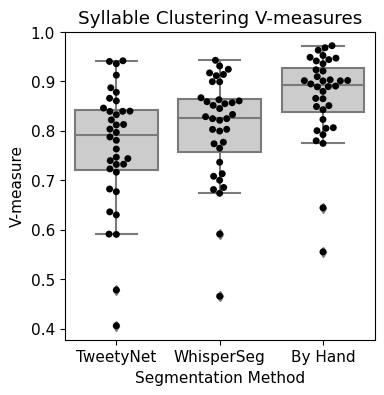

In [17]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'v_measure', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'v_measure', color = 'black', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('V-measure');

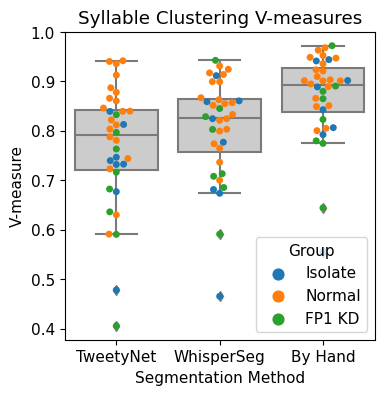

In [18]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'v_measure', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'v_measure', hue = 'Group', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('V-measure');

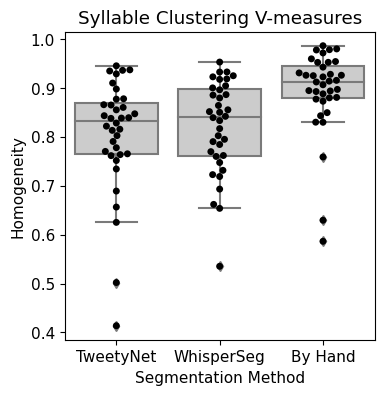

In [8]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'homogeneity', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'homogeneity', color = 'black', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('Homogeneity');

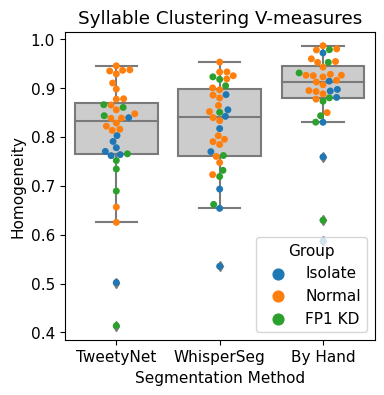

In [19]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'homogeneity', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'homogeneity', hue = 'Group', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('Homogeneity');

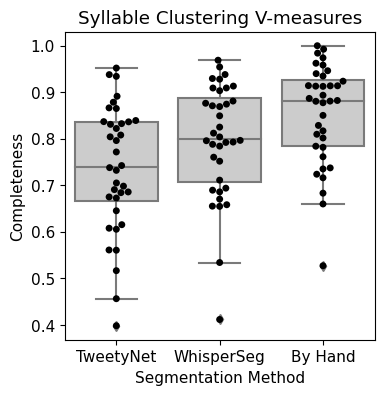

In [20]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'completeness', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'completeness', color = 'black', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('Completeness');

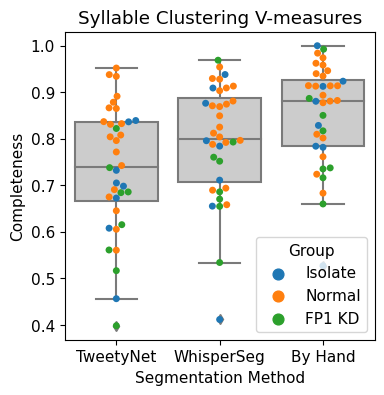

In [21]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_v_measures, x = 'segmentation_method', y = 'completeness', color = '0.8')
sns.swarmplot(data = all_v_measures, x = 'segmentation_method', y = 'completeness', hue = 'Group', s = 5)
plt.title("Syllable Clustering V-measures")
plt.xlabel('Segmentation Method')
plt.ylabel('Completeness');

### Means

In [22]:
all_v_measures

,Unnamed: 0,v_measure,homogeneity,completeness,Bird_ID,ref_db,win_length,hop_length,n_fft,K_nn,min_cluster_prop,embedding_method,embedding_dimensions,min_level_db,segmentation_method,Condition,Group
0,0,0.676886,0.763669,0.607813,B145,20,512,128,512,10,0.04,UMAP,2,-28,TweetyNet,Isolate,Isolate
1,0,0.673664,0.693169,0.655227,B145,20,512,128,512,10,0.04,UMAP,2,-28,WhisperSeg,Isolate,Isolate
2,0,0.806298,0.829863,0.784034,B145,20,512,128,512,10,0.04,UMAP,2,-28,By Hand,Isolate,Isolate
3,0,0.478078,0.502015,0.456319,B236,20,512,128,512,10,0.04,UMAP,2,-28,TweetyNet,Isolate,Isolate
4,0,0.465352,0.535223,0.411617,B236,20,512,128,512,10,0.04,UMAP,2,-28,WhisperSeg,Isolate,Isolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0,0.833039,0.864277,0.803980,Y433,20,512,128,512,10,0.04,UMAP,2,-28,WhisperSeg,GFP,Normal
104,0,0.850944,0.906594,0.801732,Y433,20,512,128,512,10,0.04,UMAP,2,-28,By Hand,GFP,Normal
105,0,0.746594,0.761593,0.732174,Y453,20,512,128,512,10,0.04,UMAP,2,-28,TweetyNet,Isolate,Isolate
106,0,0.681232,0.653755,0.711121,Y453,20,512,128,512,10,0.04,UMAP,2,-28,WhisperSeg,Isolate,Isolate


In [23]:
all_v_measures.groupby('segmentation_method').mean()

C:\Users\tkoch\AppData\Local\Temp\ipykernel_21956\2612734971.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_v_measures.groupby('segmentation_method').mean()


,Unnamed: 0,v_measure,homogeneity,completeness,ref_db,win_length,hop_length,n_fft,K_nn,min_cluster_prop,embedding_dimensions,min_level_db
segmentation_method,,,,,,,,,,,,
By Hand,0.0,0.870315,0.893555,0.852861,20.0,512.0,128.0,512.0,10.0,0.04,2.0,-28.0
TweetyNet,0.0,0.767256,0.805039,0.735966,20.0,512.0,128.0,512.0,10.0,0.04,2.0,-28.0
WhisperSeg,0.0,0.805664,0.820465,0.795641,20.0,512.0,128.0,512.0,10.0,0.04,2.0,-28.0


In [25]:
from scipy.stats import sem
print(sem(all_v_measures[all_v_measures.segmentation_method == 'WhisperSeg'].v_measure))
print(sem(all_v_measures[all_v_measures.segmentation_method == 'TweetyNet'].v_measure))
print(sem(all_v_measures[all_v_measures.segmentation_method == 'By Hand'].v_measure))

0.017183218950532125
0.020462593132348016
0.014546644305442535
